In [19]:
import pyMMF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.linalg import expm
from colorsys import hls_to_rgb
import pickle, os
from functions import cpx_corr, seq_cpx_corr, fidelity, get_disk_mask
from functions import colorize, logplotTM, get_color_map

In [20]:
DATA_PATH = './Data_18042023/'

# path to save images
IMAGE_FOLDER = './images' 
os.makedirs(IMAGE_FOLDER, exist_ok=True)

def image_path(file_name):
    return os.path.join(IMAGE_FOLDER, file_name)

In [21]:
def get_rotation_matrix(m, l, alpha):
    ''' rotation matrix in the OAM basis '''
    return np.diag(np.exp(1j*np.array(m)*alpha))

# Experimental data

## A. Load data

### Load parameters of the fiber

In [ ]:
with open(os.path.join(DATA_PATH, 'param.pkl'), 'rb') as file:
    param = pickle.load(file, encoding='latin1')


# number of pixels in each axis in the input plane (DMD)
N_in = param['fiber']['inpoints'] 
# number of pixels in each axis in the output plane (camera)
N_out = param['fiber']['onpoints'] 
# Values of displacement generating the deformation
press_steps = param['Deformation']['press_steps_treat']
# index value at which the tip enters in contact with the fiber
contact_ind = param['Deformation']['contact_ind']
press_indices = param['Deformation']['press_indices']
# number of deformation steps
n_press = param['Deformation']['n_press']

# angles of rotation of the input wavefronts
angles = param['RME']['angles']
n_a = param['RME']['n_angles']
# number of random input wavefronts
n_rnd = param['RME']['n_rnd'] 
nv_max = param['RME']['nv_max']

n_op = param['RME']['n_op']
n_rm = param['RME']['n_rm']
n_angles_for_corr = param['RME']['n_ang_corr']

# Deformation in microns
Delta_x = np.array(param['Deformation']['steps_pressure'])[press_indices]*1e3
Delta_x -= Delta_x[0]



### Load the measured output fields corresponding to rotated inputs for different deformations 

In [ ]:
# experimental data using random rotating masks
Ys_rnd = np.load(os.path.join(DATA_PATH,'Ys_rnd.npy')).astype(np.complex64)

# experimental data using for the modes of the RME operators
Ys_rm = np.load(os.path.join(DATA_PATH,'Ys_rm.npy')).astype(np.complex64)

### Load the modes

In [ ]:
modes = np.load(os.path.join(DATA_PATH,'modes.npz'))
Mout = modes['modes_out'].astype(np.complex64)
m = modes['m']
l = modes['l']

### Load the TMs in the mode basis

In [ ]:
TMs_mode = np.load(os.path.join(DATA_PATH,'TMs_mode.npy')).astype(np.complex64)
nmodes = TMs_mode.shape[-1]
TMs = TMs_mode[:,:nmodes, :] 

## B. Computation of angular memory effect correlation for random input wavefronts

In [ ]:
# take only the input polarization corresponding to the input one
Ys_rnd_p1 = Ys_rnd[...,:N_out,:]


#### Show some output fields
Note that the field are already rotated back, i.e. $Y=\mathbf{R}(-\theta)\mathbf{T}\mathbf{R}(\theta) E^\text{rnd}_\text{in}$

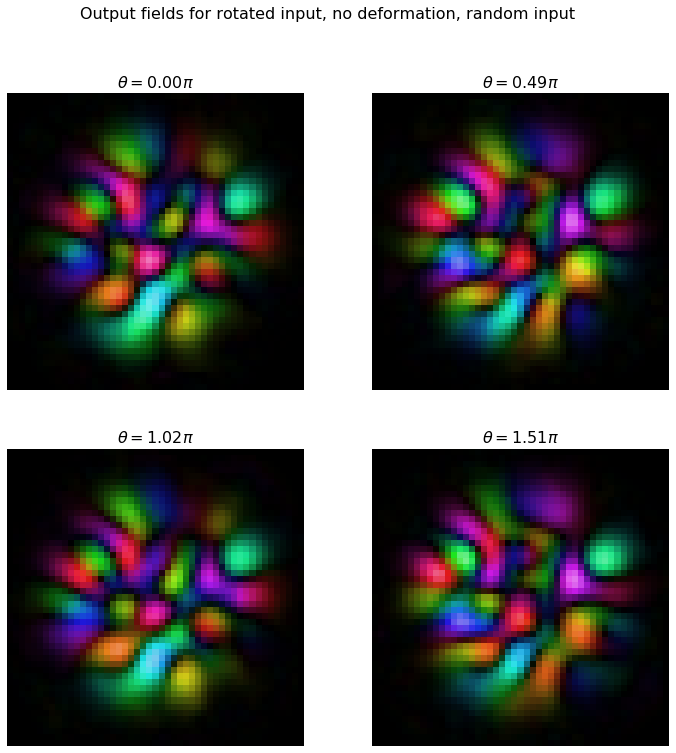

In [ ]:
def get_ind_angle(angle):
    # return the index of the angle in the array of angles
    return np.argmin(np.abs(angles-angle))

angle2show = [0, np.pi/2, np.pi, 3*np.pi/2]
ind_step = 0
ind_rnd = 0

# plot the output wavefronts
plt.figure(figsize=(12, 12))
# plot each output wavefront
for i, angle in enumerate(angle2show):
    plt.subplot(2, 2, i+1)
    ind_angle = get_ind_angle(angle)
    actual_angle = angles[ind_angle]
    field = Ys_rnd_p1[ind_step, ind_angle, ind_rnd]
    plt.imshow(colorize(field))
    plt.axis('off')
    plt.title(f'$\\theta={actual_angle/np.pi:.2f}\pi$', fontsize = 16)
    plt.suptitle(
        'Output fields for rotated input, no deformation, random input',
        fontsize = 16
    )
    

In [ ]:
Ys_rnd_p1.dtype

dtype('complex64')

In [ ]:
# reshape the two last dimensions (2d output plane) into one
Ys_rnd_p1 = Ys_rnd_p1.reshape(n_press, n_a, n_rnd, N_out**2)

In [ ]:
# create mask to focus on the central part of the output plane
mask_output = get_disk_mask([N_out, N_out],0.74*N_out/2).flatten().astype(np.complex64)

# apply mask to the experimental data on the last dimension
Ys_rnd_p1 = np.einsum('...i,i->...i', Ys_rnd_p1, mask_output)

# remove the average value (computed over the last dimension)
Ys_rnd_p1 -= np.mean(Ys_rnd_p1, axis=-1, keepdims=True)



In [ ]:
# # # project into the mode basis 
# # It allows much smaller size, so faster computation and use less memory,
# # but could be done in the spatial basis too)
# Ys_rnd_p1_mode = np.einsum('...i,ji->...i', Ys_rnd_p1, Mout.conjugate())
aaa

NameError: name 'aaa' is not defined

In [22]:
# move the axis so that the penultimate one corresponds to angles
Ys_rnd_p1 = np.moveaxis(Ys_rnd_p1, -3, -2)

In [23]:
Ys_rnd_p1.dtype

dtype('complex64')

In [24]:
Y_rnd_ref = Ys_rnd_p1[...,0,:]

: 

In [ ]:
Y_rnd_ref.shape

: 

In [60]:
def stack_correlation(A,B):
    ''' compute the correlation between two stacks of images
    A and B over the last dimension
    return the correlation between the two stacks
    '''
    C = np.einsum('...jk,...k->...j', A, B.conjugate())
    Norm1 = np.einsum('...k,...k->...', A, A.conjugate())
    Norm2 = np.einsum('...k,...k->...', B, B.conjugate())
    Norm = np.sqrt(np.einsum('...k,...->...k', Norm1, Norm2.conjugate()))
    return np.abs(C/Norm)

In [61]:
Corr_rnd = stack_correlation(Ys_rnd_p1, Y_rnd_ref)

In [ ]:
# # Correlation
# Corr_rnd_all = np.abs(np.einsum('ijkl,ijkl->ikj', Ys_rnd_p1_mode,Y_rnd_ref.conjugate()))

# Norm1 = np.sqrt(np.einsum('ijkl,ijkl->ikj', Ys_rnd_p1_mode,Ys_rnd_p1_mode.conjugate()))
# Norm2 = np.sqrt(np.einsum('ijkl,ijkl->ikj', Y_rnd_ref,Y_rnd_ref.conjugate()))
# Norm = np.einsum('ikj,ikj->ikj', Norm1, Norm2)

: 

In [ ]:
# compute the correlation coefficients between the rotated outputs and the output for rotated inputs
corr_rnd = seq_cpx_corr(Ys_rnd_p1_mode, n_angles_for_corr)

: 

In [ ]:
Ys_rnd_p1_mode[:,0,...].shape

: 

In [ ]:
Ys_rnd_p1_mode.shape

: 

In [ ]:
# ## Rotation matrices for all angles of rotation
# R_mats = np.array([get_rotation_matrix(m, l, a) for a in angles])

: 

In [ ]:
# Norm1 = np.sqrt(np.einsum('ijkl,ijkl->ikj', Ys_rnd_p1_mode,Ys_rnd_p1_mode.conjugate()))
# Norm2 = np.sqrt(np.einsum('ijkl,ijkl->ikj', Y_rnd_ref,Y_rnd_ref.conjugate()))
# Norm = np.einsum('ikj,ikj->ikj', Norm1, Norm2)
# # Corr_rnd_avg/Norm
# Corr_rnd = Corr_rnd_all/Norm#np.einsum('ikj,ikj->ikj', Corr_rnd_all, 1/Norm)


: 

In [56]:
Corr_rnd.shape

(30, 100, 50)

In [62]:
# Average over the realization of random inputs
Corr_rnd_avg = np.mean(Corr_rnd, axis=-2) 

In [63]:
Corr_rnd_avg.shape

(30, 50)

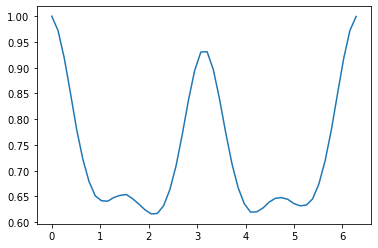

In [65]:
ind_step = 0

plt.figure()
plt.plot(angles,Corr_rnd_avg[ind_step,:])

In [ ]:

rnd_corr_p1 = np.zeros((n_press, n_a, n_rnd),complex)
for step, Ystep in tqdm(enumerate(Ys_rnd)):
    for ind, Yrnd in enumerate(np.moveaxis(Ystep,1,0)):
        rnd_corr_p1[step,:,ind] = seq_cpx_corr(Yrnd[...,:N_out,:].reshape(n_a,-1), remove_mean=True, mask=mask_corr)
Corr_mean_exp = np.mean(np.abs(rnd_corr_p1),axis=-1)

: 

## Computation of the correlation for the fiber modes

In [ ]:
## Rotation matrices for all angles of rotation
R_mats = np.array([get_rotation_matrix(m, l, a) for a in angles])
## All input modes one by one in the mode basis, i.e. an identity matrix
E_in = np.eye(nmodes, dtype = np.complex64)

: 

In [ ]:
Mout.shape # 0: n_angles, n_out_modes, n_in_modes 

: 

: 

: 

**Compute output for each input fiber mode and each deformation** 

In [ ]:
# Y_modes = np.einsum('ijk,ljm,mn->ilnj', TMs, R_mats, E_in)
# for each rotated input, index 'l'
Y_modes = np.einsum('ijk,lkm->ilmj', TMs, R_mats)

: 

In [ ]:
Y_modes.shape # num_deformations x num_angles x num_modes(input channels) x num_out(=nmodes)

: 

In the pixel basis

In [ ]:
Y_modes_pix = np.einsum('ijkl,lm->ijkm', Y_modes, Mout)

: 

In [ ]:
ind_step = -1
ind_mode = 1
plt.figure()
plt.imshow(colorize(Y_modes_pix[ind_step, 0, ind_mode].reshape([N_out]*2)))

: 

**Compute correlation between all angles and angle = 0 for all the parameters**

In [ ]:
# Rotated output
Y_modes_ref = np.einsum('lkn,imn->ilmk', R_mats, Y_modes[:,0,...].conjugate())
# Correlation
Corr_modes = np.abs(np.einsum('ijkl,ijkl->ikj', Y_modes,Y_modes_ref))

: 

: 

**Normalize**

In [ ]:
Norm1 = np.sqrt(np.einsum('ijkl,ijkl->ikj', Y_modes,Y_modes.conjugate()))
Norm2 = np.sqrt(np.einsum('ijkl,ijkl->ikj', Y_modes_ref,Y_modes_ref.conjugate()))
Norm = np.einsum('ikj,ikj->ikj', Norm1, Norm2)
Corr_modes = Corr_modes/Norm

: 

**Corr_modes** -> first index: deformation, second index: channels (fiber modes), third index: angles

In [ ]:
ind_mode = 6

plt.figure()
plt.plot(angles,Corr_modes[0,ind_mode,:])

: 

In [ ]:
Y_mode = Y_modes[...,ind_mode,:]

: 

In [ ]:
mask_corr = get_disk_mask([N_out, N_out],0.74*N_out/2)
rnd_corr_p1 = np.zeros((n_press, n_a, n_rnd),complex)
for step, Ystep in tqdm(enumerate(Y_mode)):
    rnd_corr_p1[step,:,ind] = seq_cpx_corr(Yrnd[...,:N_out,:].reshape(n_a,-1), remove_mean=True, mask=mask_corr)
Corr_mean_exp = np.mean(np.abs(rnd_corr_p1),axis=-1)

: 

## Computation of correlation for the modes of the RME operators

In [ ]:
rm_corr = np.zeros((n_press, n_op, n_rm, n_a), complex)
for ind_p in tqdm(range(n_press)):
    for op_i in range(n_op):
        for ind_rm in range(n_rm):
            rm_corr[ind_p, op_i, ind_rm] = seq_cpx_corr(Ys_rm[ind_p, op_i,:,ind_rm,:N_out].reshape(n_a,-1))

: 

In [ ]:
N_out

: 

In [ ]:
Y_modes_pix = np.einsum('ijkl,lm->ijkm', Y_modes, Mout)

: 

In [ ]:
# ind_2_plot = [0,8,16,24]
# op_to_show = np.arange(n_op)
op_to_show = [0,2]
n_op = len(op_to_show)
ind_2_plot = [3,12,21,29]
inds_mode = [0,1]
# cmap = get_color_map(len(ind_2_plot))
line_cmap = matplotlib.cm.get_cmap('viridis')
color_list = [line_cmap(0+i/(n_op)) for i in range(n_op)]
lbl_list = [r'$\hat O_{corr} (\pi /2) $' , 
            r'$\hat O_{corr} (3\pi /2) $', 
            r'$\hat O_{corr} (\pi/4,\pi /2,3\pi/4,5\pi/4 ,3\pi /2,7\pi/4) $',
            r'$\hat O_{comm} (\pi /2) $' , 
            r'$\hat O_{comm} (3\pi /2) $']

fig, axs = plt.subplots(2,2,figsize = (12,9))


for ind_mode in inds_mode:
    for ind_p, ax in enumerate(axs.ravel()):
        for i, op in enumerate(op_to_show):
            ax.plot(angles,np.abs(rm_corr[ind_2_plot[ind_p],op,ind_mode]),c=color_list[i], label=lbl_list[op])
        ax.plot(angles,Corr_mean_exp[ind_2_plot[ind_p]],'r--')
        ax.set_title(rf'$\Delta x = {Delta_x[ind_p]:.2f}\mu m$', fontsize = 16)
   
for ind_p, ax in enumerate(axs.ravel()):
    ax.plot(angles,np.abs(Corr_modes[ind_2_plot[ind_p],0]),'r--')
    ax.plot(angles,np.abs(Corr_modes[ind_2_plot[ind_p],1]),'r--')
    ax.plot(angles,np.abs(Corr_modes[ind_2_plot[ind_p],4]),'r--')
    

# axs[0,0].legend(prop={'size': 10})
for i in range(2):
    axs[1,i].set_xlabel(r'rotation angle $\theta$', fontsize=16)
    axs[i,0].set_ylabel('Correlation', fontsize=16)

xticks = [0,np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
xtics_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
for ax in axs.ravel():
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xticks(ticks = xticks)
    ax.set_xticklabels(xtics_labels, fontsize = 16)
    ax.set_ylim([0.5,1])
    ax.grid()
ax.set_ylim([0.1,1])

formula = r'$\left\|C(\mathbf{T}\left|\psi\right\rangle,\mathbf{R}^{-1}\mathbf{T}\mathbf{R}\left|\psi\right\rangle)\right|$'
plt.suptitle(formula, fontsize = 16)

fig.savefig(image_path('rot_modes_deform.svg'),bbox_inches='tight')

: 

In [ ]:
ind_step = 0
ind_op = 2
ind_mode = 1
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(colorize(Ys_rm[ind_step, ind_op,0,ind_mode,:N_out,:]))
plt.axis('off')
plt.title(rf'$\theta=0$', fontsize = 16)
plt.subplot(222)
plt.imshow(colorize(Ys_rm[ind_step, ind_op,n_a//4,ind_mode,:N_out,:]))
plt.axis('off')
plt.title(rf'$\theta=\pi/2$', fontsize = 16)
plt.subplot(223)
plt.imshow(np.abs(Ys_rm[ind_step, ind_op,0,ind_mode,:N_out,:])**2)
plt.axis('off')
plt.title(rf'$\theta=0$', fontsize = 16)
plt.subplot(224)
plt.imshow(np.abs(Ys_rm[ind_step, ind_op,n_a//4,ind_mode,:N_out,:])**2)
plt.axis('off')
plt.title(rf'$\theta=\pi/2$', fontsize = 16)
plt.suptitle(lbl_list[ind_op]+ rf', #{ind_mode},  $\Delta x={Delta_x[ind_step]:.2f}\mu m$', y = 1.05, fontsize = 16);
# plt.tight_layout(pad =20)

: 

In [ ]:
list(modes.keys())

: 

In [ ]:
E_in

: 

In [ ]:
ind_mode = 4

TM = TMs[ind_p]
E_in = modes['modes_in_corr'][ind_mode].reshape([30]*2)

plt.figure()
plt.imshow(colorize(E_in))

: 

In [ ]:
TM.shape

: 

In [ ]:
mask_corr = get_disk_mask([N_out, N_out],0.74*N_out/2)
mode_corr_p1 = np.zeros((n_press, n_a, n_rnd),complex)
for step, Ystep in tqdm(enumerate(Ys_rnd)):
    for ind, Yrnd in enumerate(np.moveaxis(Ystep,1,0)):
        rnd_corr_p1[step,:,ind] = mode_corr_p1(Yrnd[...,:N_out,:].reshape(n_a,-1), remove_mean=True, mask=mask_corr)
Corr_mean_exp = np.mean(np.abs(mode_corr_p1),axis=-1)

: 

: 

In [ ]:
# deformation index
ind_p = 0
# operator index
op_i = 0

# index of the mode
ind_rm = 4

# index the angle
ind_angle = 0

pattern = Ys_rm[ind_p, op_i,ind_angle,ind_rm,:N_out]

: 

In [ ]:
plt.figure()
plt.imshow(np.abs(pattern))

: 

: 

: 

: 

: 

: 